In [3]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 

import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import predestination  # Global Random seed for reproducibilty.
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


# Let's seed the various PRNGs, for reproducibility,
# using de default seed.
#
# Note1: this cannot apply to SQLite Random() function,
#       so its use is forbidden. e.g ORDER BY RANDOM()
#       should not be used in an sql query.
#
# Note2: repeated execution of a any cell requiring
#        randomness WILL NOT give the same result unless
#        predestination invocation was done from this cell
predestination()

# Dataset name is the master key for dataset adressing
# Changing according to the dataset you want to process
DATASET_NAME = 'DUO1000_8kHz'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Get pandas dataframe containing the columns we will need for this experiments
sql = "select mfcc20, mfcc20_std, std_mfcc20, std_mfcc20_std, std_mfcc8, std_apidictor, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql)



[2020-08-20/00:08:03.022|35.8%|71.4%|0.55GB] ------------------------------------------------------
[2020-08-20/00:08:03.022|00.0%|71.4%|0.55GB] DATASET NAME          : DUO1000_8kHz
[2020-08-20/00:08:03.022|00.0%|71.4%|0.55GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\DUO1000_8kHz
[2020-08-20/00:08:03.022|00.0%|71.4%|0.55GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\DUO1000_8kHz\DUO1000_8kHz.db
[2020-08-20/00:08:03.023|00.0%|71.4%|0.55GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\DUO1000_8kHz\samples
[2020-08-20/00:08:03.023|00.0%|71.4%|0.55GB] NB SOURCE AUDIO FILES : 4
[2020-08-20/00:08:03.023|00.0%|71.4%|0.55GB] SAMPLE RATE           : 8192
[2020-08-20/00:08:03.023|00.0%|71.4%|0.55GB] DURATION              : 1.0
[2020-08-20/00:08:03.023|00.0%|71.4%|0.55GB] OVERLAP               : 0.0
[2020-08-20/00:08:03.025|37.5%|71.4%|0.55GB] NB AUDIO CHUNKS       : 2374
[2020-08-20/00:08:03.025|00.0%|71.4%|0.55GB] ---------------------------------------------------

In [4]:
from sklearn.model_selection import train_test_split
# Seed the various PRNGs
predestination()

FEATURE_NAME = 'mfcc20'

features = []
for v in df[FEATURE_NAME]:
    features.append(v.flatten().tolist())

TEST_FRAC = 0.3

X_train, X_test, y_train, y_test = train_test_split(features, df['queen'], test_size=TEST_FRAC)

In [5]:
from sklearn import svm
from sklearn import metrics

# Seed the various PRNGs
predestination()

KERNEL='rbf'



#Create a svm Classifier
clf = svm.SVC(kernel=KERNEL, verbose=True, C=100)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


print("train", y_train.shape)
print("pred", y_pred.shape)
print("test", y_test.shape)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))


[LibSVM]train (1057,)
pred (453,)
test (453,)
Accuracy: 0.9690949227373068
Precision: 0.9766355140186916
Recall: 0.9587155963302753
F1: 0.9675925925925927


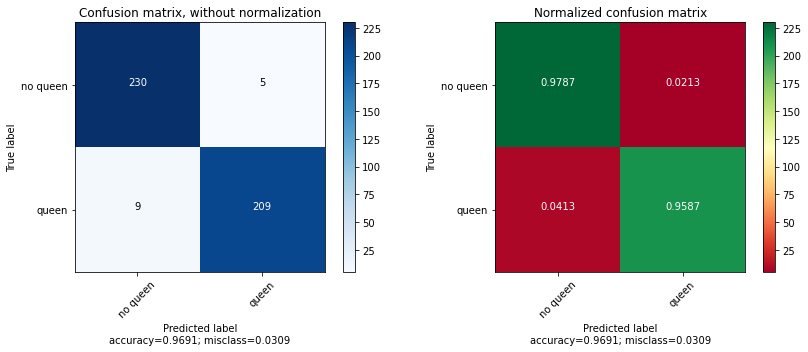




              precision    recall  f1-score   support

    no queen       0.96      0.98      0.97       235
       queen       0.98      0.96      0.97       218

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



In [6]:
import matplotlib.pyplot as plt
from audace.plotters import plot_confusion_matrix, save_fig
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names=['no queen', 'queen']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred )


ROWS=1
plt.figure(figsize=(12, 5))

plt.subplot(121)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, target_names=target_names, normalize=False,
                      title='Confusion matrix, without normalization')

plt.subplot(122)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, target_names=target_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.RdYlGn)

plt.tight_layout()
save_fig("03 - SVM Confusion Matrices")
plt.show()

print("\n\n")
print(classification_report(y_test, y_pred , target_names=target_names))



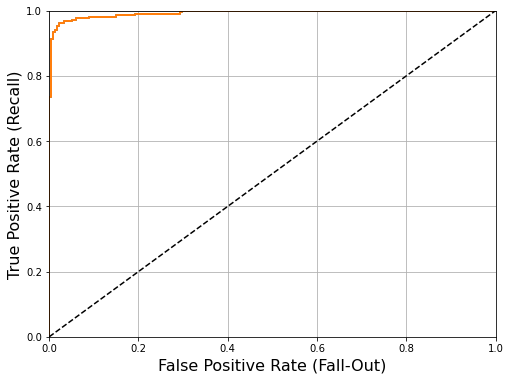

Area Under Curve 0.9932071052117899


In [7]:
from sklearn.metrics import roc_curve
from audace.plotters import plot_roc_curve
from sklearn.metrics import roc_auc_score

y_scores = clf.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, linewidth=2, label='urg')
plot_roc_curve(fpr, tpr)
plt.show()


print('Area Under Curve', roc_auc_score(y_test, y_scores))

In [13]:
df1 = ds.queryDataFrame("select mfcc20, mfcc20_std, std_mfcc20, std_mfcc20_std, std_mfcc8, std_apidictor, queen from samples where nobee = 0 and hive = 'Hive1'")
df3 = ds.queryDataFrame("select mfcc20, mfcc20_std, std_mfcc20, std_mfcc20_std, std_mfcc8, std_apidictor, queen from samples where nobee = 0 and hive = 'Hive3'")

FEATURE_NAME = 'mfcc20_std'
KERNEL='rbf'

X1 = []
for v in df1[FEATURE_NAME]:
    X1.append(v.flatten().tolist())

y1 = df1['queen'].values
    
    
X3 = []
for v in df3[FEATURE_NAME]:
    X3.append(v.flatten().tolist())
    
y3 = df3['queen'].values
    


In [14]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics


#Create a svm Classifier
clf1 = svm.SVC(kernel=KERNEL)

#Train the model using the training sets
clf1.fit(X1, y1)

#Predict the response for test dataset
y3_pred = clf1.predict(X3)

print("Accuracy:",metrics.accuracy_score(y3, y3_pred))
print("Precision:",metrics.precision_score(y3, y3_pred))
print("Recall:",metrics.recall_score(y3, y3_pred))
print("F1:",metrics.f1_score(y3, y3_pred))

#Create a svm Classifier
clf3 = svm.SVC(kernel=KERNEL)

#Train the model using the training sets
clf3.fit(X3, y3)

#Predict the response for test dataset
y1_pred = clf3.predict(X1)

print("Accuracy:",metrics.accuracy_score(y1, y1_pred))
print("Precision:",metrics.precision_score(y1, y1_pred))
print("Recall:",metrics.recall_score(y1, y1_pred))
print("F1:",metrics.f1_score(y1, y1_pred))



Accuracy: 0.571830985915493
Precision: 0.0
Recall: 0.0
F1: 0.0
Accuracy: 0.505
Precision: 0.0
Recall: 0.0
F1: 0.0
